Reference: **[Residual Networks (ResNet) - Deep Learning](https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/)**

Modified by the help of ChatGPT

## 1. Importing keras APIs and modules.
These APIs help in building the architecture of the ResNet Module

In [11]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import json
from pathlib import Path
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

## 2. Hyper parameters and pre-processing

In [18]:
batch_size = 64
epochs = 200
data_augmentation = True
subtract_pixel_mean = True
n = 3
version = 1

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = 'ResNet % dv % d' % (depth, version)

# Load COCO annotations
dataset_path = Path('dashcam 2.v1i.coco/train')
annotations_file = dataset_path / '_annotations.coco.json'

with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

# Parse COCO format
images_info = {img['id']: img for img in coco_data['images']}
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Group annotations by image (for multilabel)
annotations_by_image = {}
for annotation in coco_data['annotations']:
    img_id = annotation['image_id']
    cat_id = annotation['category_id']
    cat_name = categories[cat_id]
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(cat_name)

# Load images and multilabel annotations
x_train = []
y_train = []

for img_id, img_info in images_info.items():
    img_path = dataset_path / img_info['file_name']
    
    # Read and preprocess image
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))  # Resize to match CIFAR-10 size
    x_train.append(img)
    
    # Get multilabel (list of category names)
    labels = annotations_by_image.get(img_id, [])
    y_train.append(labels)

x_train = np.array(x_train, dtype='float32') / 255

# MultiLabelBinarizer for multilabel encoding
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)

num_classes = len(mlb.classes_)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train_encoded.shape)
print('Classes:', mlb.classes_)
print('Number of classes:', num_classes)

x_train shape: (2484, 32, 32, 3)
2484 train samples
y_train shape: (2484, 4)
Classes: ['Mobil' 'Motor' 'Orang' 'Truk']
Number of classes: 4


## 3. Learning Rate Schedule
Used to adjust learning rate based on the amount of epochs.

In [19]:
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

## 4. Basic ResNet Building Block

In [21]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

## 5. Defining ResNet Architecture

In [15]:
def resnet_v1(input_shape, depth, num_classes=10): 
    if (depth - 2) % 6 != 0: 
        raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])') 

    num_filters = 16
    num_res_blocks = int((depth - 2) / 6) 

    inputs = Input(shape=input_shape) 
    x = resnet_layer(inputs=inputs) 

    for stack in range(3): 
        for res_block in range(num_res_blocks): 
            strides = 1
            if stack > 0 and res_block == 0: 
                strides = 2 
            y = resnet_layer(inputs=x, 
                             num_filters=num_filters, 
                             strides=strides) 
            y = resnet_layer(inputs=y, 
                             num_filters=num_filters, 
                             activation=None) 
            if stack > 0 and res_block == 0: 
                x = resnet_layer(inputs=x, 
                                 num_filters=num_filters, 
                                 kernel_size=1, 
                                 strides=strides, 
                                 activation=None, 
                                 batch_normalization=False) 
            x = keras.layers.add([x, y]) 
            x = Activation('relu')(x) 
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x) 
    y = Flatten()(x) 
    outputs = Dense(num_classes, 
                    activation='softmax', 
                    kernel_initializer='he_normal')(y) 

    model = Model(inputs=inputs, outputs=outputs) 
    return model

## 6. Train and test the model

In [22]:
model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.keras' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_acc',
                              verbose=1,
                              mode='max',
                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)
# This creates a "watcher"
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  # Watch the validation accuracy
    factor=0.5,              # Reduce LR by half (multiply by 0.5) when stuck. (Not 0.01!)
    patience=10,             # Wait 10 epochs before reducing (give it a chance to recover)
    min_lr=1e-6,             # Don't let it go below this number
    verbose=1                # Print a message when it updates
)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [lr_reducer, lr_scheduler]

# Modify the training section to capture history
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train_encoded,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        shuffle=True,
                        callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        zca_whitening=False,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    datagen.fit(x_train)

    split_idx = int(0.8 * len(x_train))
    x_train_split = x_train[:split_idx]
    y_train_split = y_train_encoded[:split_idx]
    x_val = x_train[split_idx:]
    y_val = y_train_encoded[split_idx:]

    history = model.fit(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                        steps_per_epoch=x_train_split.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=callbacks)

Learning rate:  0.0001


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_57[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_58[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 32, 32,    │          0 │ activation_57[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 32, 32,    │          0 │ add_27[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_59[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_60[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 32, 32,    │          0 │ activation_59[0]

 Total params: 274,052 (1.05 MB)

 Trainable params: 272,676 (1.04 MB)

 Non-trainable params: 1,376 (5.38 KB)

ResNet  20v  1
Using real-time data augmentation.
Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.3599 - loss: 2.8474 - val_accuracy: 0.2213 - val_loss: 3.8115 - learning_rate: 1.0000e-04
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 2.0124 - val_accuracy: 0.2213 - val_loss: 3.7722 - learning_rate: 1.0000e-04
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.4056 - loss: 2.1202 - val_accuracy: 0.3722 - val_loss: 2.2580 - learning_rate: 1.0000e-04
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3906 - loss: 2.0739 - val_accuracy: 0.3642 - val_loss: 2.2117 - learning_rate: 1.0000e-04
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.4342 - loss: 1.9169 - val_accuracy: 0.4145 - val_loss: 1.9410 - learning_rate: 1.0000e-04
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5312 - loss: 1.7237 - val_accuracy: 0.4205 - val_loss: 1.9433 - learning_rate: 1.0000e-04
Epoch 7/200


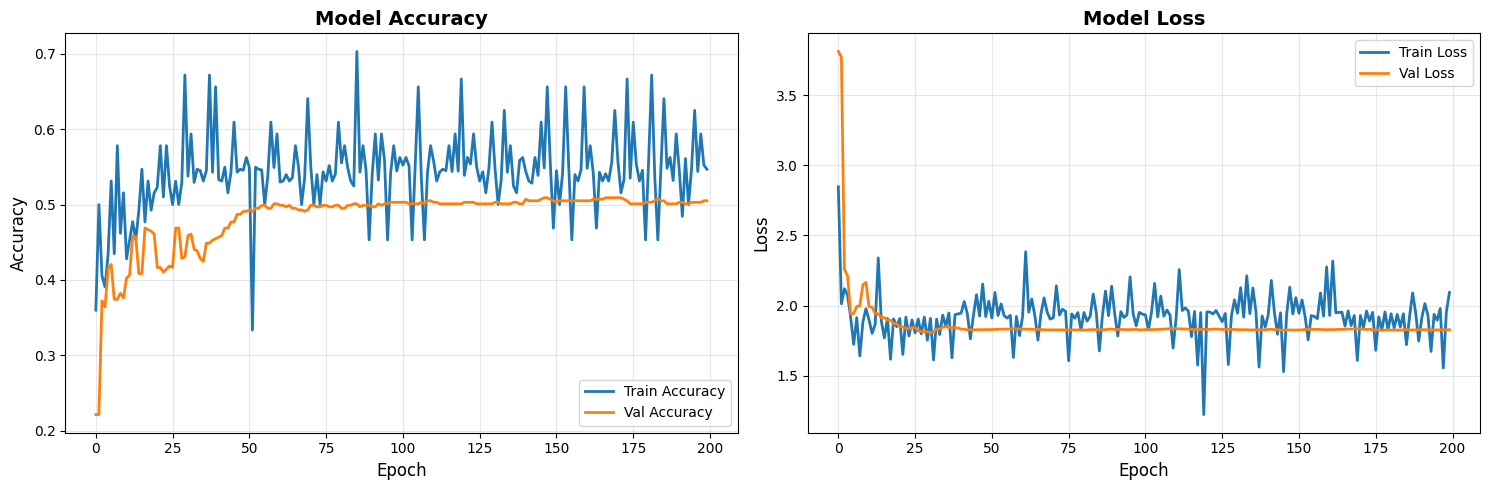

Training history plot saved as 'training_history.png'


In [23]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

model.save('resnet_multilabel_model.h5')

print("Training history plot saved as 'training_history.png'")